In [3]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
#stock_data.head()

In [4]:
#stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data = yf.download('AAPL', start='2010-01-01', end='2021-10-01')

stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.496294,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507527,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404015,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392177,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434673,447610800


In [5]:
training_data_len = math.ceil(len(stock_data)* 0.8)
training_data_len

2366

In [6]:
cols = list(stock_data)[0:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [7]:
stock_data = stock_data[cols].astype(float)


In [8]:
stock_data.shape

(2957, 6)

In [9]:
trainX = []
trainY = []
testX = []
testY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 42  # Number of past days we want to use to predict the future.


In [10]:
train_df = stock_data.iloc[0:training_data_len]
test_df = stock_data.iloc[training_data_len-n_past:]

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(train_df)
train_df_scaled = scaler.transform(train_df)


In [12]:
test_df_scaled = scaler.transform(test_df)

In [13]:
testX = []
testY = []

In [14]:
for i in range(n_past, len(train_df_scaled) - n_future +1):
    trainX.append(train_df_scaled[i - n_past:i, 0:train_df_scaled.shape[1]])
    trainY.append(train_df_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (2324, 42, 6).
trainY shape == (2324, 1).


In [15]:
for i in range(n_past, len(test_df_scaled) - n_future +1):
    testX.append(test_df_scaled[i - n_past:i, 0:test_df_scaled.shape[1]])
    testY.append(test_df_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))


testX shape == (591, 42, 6).
testY shape == (591, 1).


In [16]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


In [17]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 42, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
131/131 [==============================] - 5s 24ms/step - loss: 0.0895 - val_loss: 0.0592
Epoch 2/30
131/131 [==============================] - 3s 23ms/step - loss: 0.0269 - val_loss: 0.0239
Epoch 3/30
131/131 [==============================] - 3s 20ms/step - loss: 0.0251 - val_loss: 0.0984
Epoch 4/30
131/131 [==============================] - 3s 21ms/step - loss: 0.0262 - val_loss: 0.2015
Epoch 5/30
131/131 [==============================] - 3s 20ms/step - loss: 0.0250 - val_loss: 0.0300
Epoch 6/30
131/131 [==============================] - 3s 21ms/step - loss: 0.0259 - val_loss: 0.0340
Epoch 7/30
131/131 [==============================] - 3s 20ms/step - loss: 0.0232 - val_loss: 0.0740
Epoch 8/30
131/131 [==============================] - 3s 21ms/step - loss: 0.0236 - val_loss: 0.0354
Epoch 9/30
131/131 [==============================] - 3s 22ms/step - loss: 0.0206 - val_loss: 0.0118
Epoch 10/30
131/131 [==============================] - 3s 22ms/step - loss: 0.0230 - val_lo

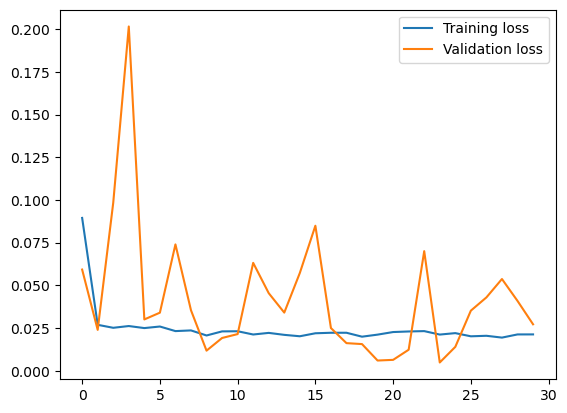

In [18]:
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [19]:
predictions = model.predict(testX)
prediction_copies = np.repeat(predictions, test_df.shape[1], axis=-1)

predictions = scaler.inverse_transform(prediction_copies)[:,0]
rmse = np.sqrt(np.mean(predictions - testY)**2)
rmse


19/19 [==============================] - 0s 9ms/step


75.52170462879604

In [40]:
predictions

array([ 52.2793  ,  52.28568 ,  53.52183 ,  52.817455,  51.085873,
        48.838486,  48.95428 ,  49.526104,  50.59556 ,  50.735783,
        50.57557 ,  51.873478,  51.358807,  50.725636,  51.388485,
        52.526577,  52.900543,  53.145687,  53.067017,  51.313297,
        51.315174,  51.267696,  51.284664,  52.033768,  52.35095 ,
        51.673695,  52.093933,  53.089046,  53.384098,  53.51071 ,
        53.790615,  55.135395,  55.685658,  54.46894 ,  54.164852,
        54.40639 ,  54.936848,  54.980007,  54.571293,  54.238132,
        54.301384,  54.631966,  54.661713,  54.488274,  55.32808 ,
        56.004803,  54.764072,  54.36638 ,  55.72054 ,  56.372746,
        55.928688,  56.004234,  56.635475,  58.029102,  58.247864,
        57.980675,  57.45639 ,  57.515648,  57.908524,  58.8176  ,
        59.059097,  59.44397 ,  59.552246,  59.986534,  60.66651 ,
        59.84484 ,  59.23689 ,  59.95675 ,  61.811363,  62.665188,
        62.486954,  62.105953,  62.66182 ,  62.742435,  63.193

In [55]:
data = stock_data.filter(['Open'])
#train = data[:training_data_len]
#validation = data[training_data_len:]
#validation['Predictions'] = predictions
#validation

In [57]:
stock_data

,High,Low,Close,Adj Close,Volume
Date,,,,,
2010-01-04,7.660714,7.585000,7.643214,6.496295,493729600.0
2010-01-05,7.699643,7.616071,7.656429,6.507526,601904800.0
2010-01-06,7.686786,7.526786,7.534643,6.404016,552160000.0
2010-01-07,7.571429,7.466071,7.520714,6.392174,477131200.0
2010-01-08,7.571429,7.466429,7.570714,6.434673,447610800.0
...,...,...,...,...,...
2021-09-24,147.470001,145.559998,146.919998,145.435822,53477900.0
2021-09-27,145.960007,143.820007,145.369995,143.901489,74150700.0
2021-09-28,144.750000,141.690002,141.910004,140.476456,108972300.0


C:\Users\yotam\AppData\Local\Temp\ipykernel_7320\2903581851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


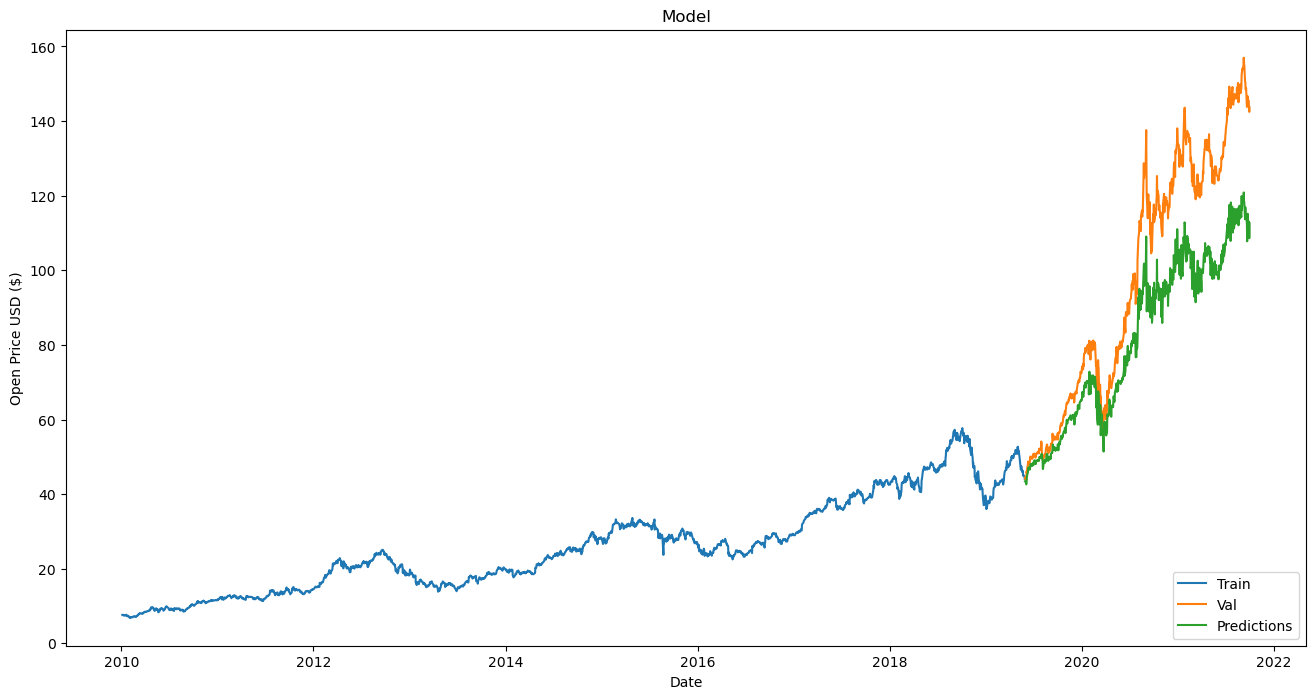

In [20]:
data = stock_data.filter(['Open'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train)
plt.plot(validation[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# now with diff

In [43]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Open_dif
Date,,,,,,,
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507527,601904800.0,0.005452
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404015,552160000.0,-0.001026
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392177,477131200.0,-0.012420
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434673,447610800.0,-0.006895
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.377911,462229600.0,0.011748
...,...,...,...,...,...,...,...
2021-09-24,145.660004,147.470001,145.559998,146.919998,145.435822,53477900.0,-0.006797
2021-09-27,145.470001,145.960007,143.820007,145.369995,143.901474,74150700.0,-0.001306
2021-09-28,143.250000,144.750000,141.690002,141.910004,140.476425,108972300.0,-0.015497


In [28]:
stock_diff = stock_data.diff()


In [42]:
stock_data['Open_dif'] = stock_diff['Open']/stock_data['Open']
stock_data = stock_data.iloc[1:]

In [44]:
trainX = []
trainY = []
testX = []
testY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 42  # Number of past days we want to use to predict the future.


In [45]:
train_df = stock_data.iloc[0:training_data_len]
test_df = stock_data.iloc[training_data_len-n_past:]

In [46]:
scaler = StandardScaler()
scaler = scaler.fit(train_df)
train_df_scaled = scaler.transform(train_df)


In [47]:
test_df_scaled = scaler.transform(test_df)


In [48]:
train_df

,Open,High,Low,Close,Adj Close,Volume,Open_dif
Date,,,,,,,
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507527,601904800.0,0.005452
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404015,552160000.0,-0.001026
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392177,477131200.0,-0.012420
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434673,447610800.0,-0.006895
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.377911,462229600.0,0.011748
...,...,...,...,...,...,...,...
2019-05-23,44.950001,45.134998,44.452499,44.915001,43.577549,146118800.0,-0.027030
2019-05-24,45.049999,45.535000,44.654999,44.742500,43.410183,94858800.0,0.002220
2019-05-28,44.730000,45.147499,44.477501,44.557499,43.230694,111792800.0,-0.007154


In [49]:
for i in range(n_past, len(train_df_scaled) - n_future +1):
    trainX.append(train_df_scaled[i - n_past:i, 0:train_df_scaled.shape[1]])
    trainY.append(train_df_scaled[i + n_future - 1:i + n_future, 6])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (2324, 42, 7).
trainY shape == (2324, 1).


In [50]:
for i in range(n_past, len(test_df_scaled) - n_future +1):
    testX.append(test_df_scaled[i - n_past:i, 0:test_df_scaled.shape[1]])
    testY.append(test_df_scaled[i + n_future - 1:i + n_future, 6])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))


testX shape == (590, 42, 7).
testY shape == (590, 1).


In [51]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


In [52]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 42, 64)            18432     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30881 (120.63 KB)
Trainable params: 30881 (120.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
131/131 [==============================] - 5s 23ms/step - loss: 0.9954 - val_loss: 1.1221
Epoch 2/30
131/131 [==============================] - 3s 19ms/step - loss: 0.9921 - val_loss: 1.1131
Epoch 3/30
131/131 [==============================] - 3s 20ms/step - loss: 0.9888 - val_loss: 1.1106
Epoch 4/30
131/131 [==============================] - 3s 20ms/step - loss: 0.9907 - val_loss: 1.1142
Epoch 5/30
131/131 [==============================] - 3s 20ms/step - loss: 0.9902 - val_loss: 1.1144
Epoch 6/30
131/131 [==============================] - 3s 20ms/step - loss: 0.9897 - val_loss: 1.1141
Epoch 7/30
131/131 [==============================] - 3s 22ms/step - loss: 0.9885 - val_loss: 1.1139
Epoch 8/30
131/131 [==============================] - 3s 22ms/step - loss: 0.9865 - val_loss: 1.1138
Epoch 9/30
131/131 [==============================] - 3s 23ms/step - loss: 0.9866 - val_loss: 1.1894
Epoch 10/30
131/131 [==============================] - 3s 21ms/step - loss: 0.9820 - val_lo

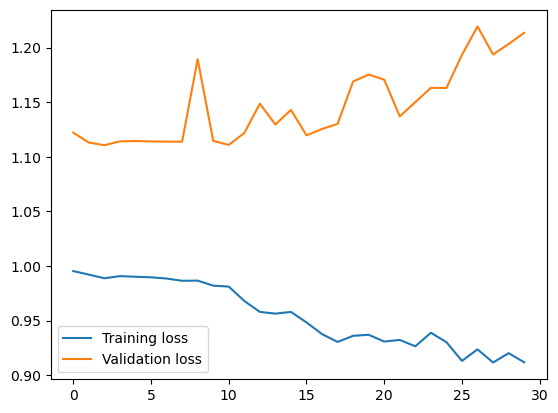

In [53]:
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [54]:
predictions = model.predict(testX)
prediction_copies = np.repeat(predictions, test_df.shape[1], axis=-1)

predictions = scaler.inverse_transform(prediction_copies)[:,0]
rmse = np.sqrt(np.mean(predictions - testY)**2)
rmse


19/19 [==============================] - 0s 10ms/step


22.31248984847949

In [55]:
print("gees 0: ",np.sqrt(np.mean(-testY)**2))

gees 0:  0.06563914280916203


C:\Users\yotam\AppData\Local\Temp\ipykernel_7320\646207287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


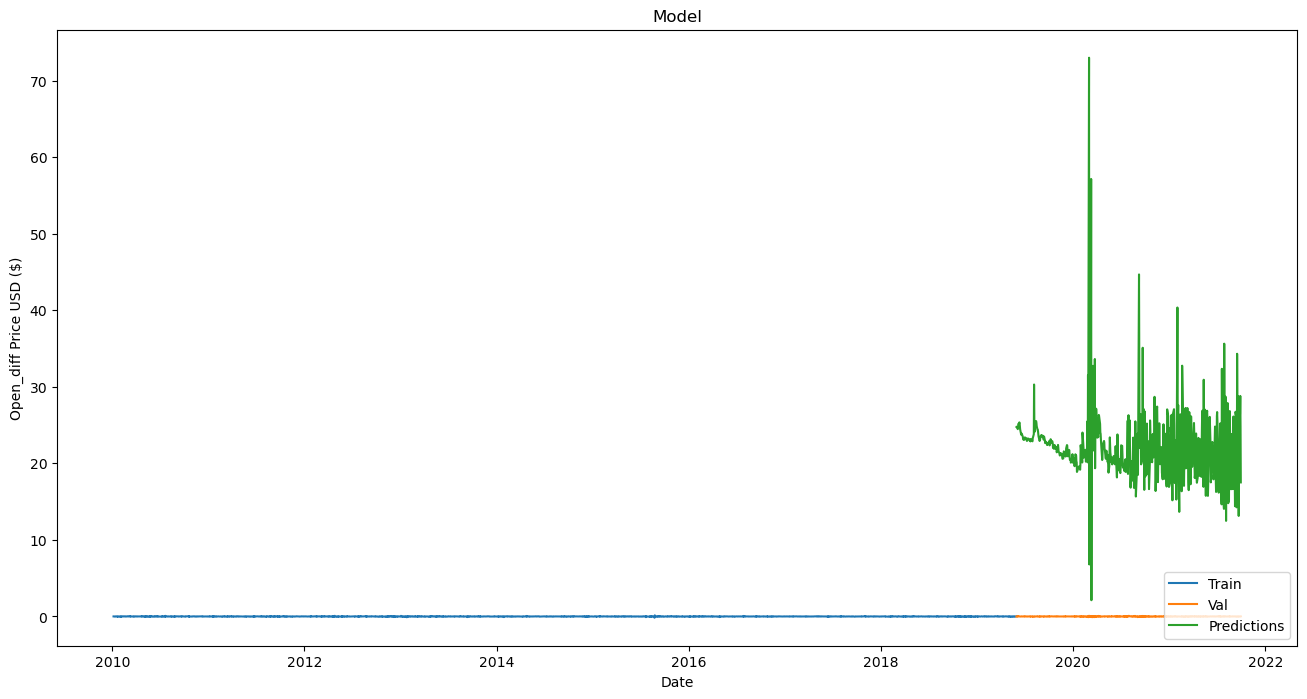

In [57]:
data = stock_data.filter(['Open_dif'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open_diff Price USD ($)')
plt.plot(train)
plt.plot(validation[['Open_dif', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()